# XGBoost Regressor Hyperparameter Optimization

This notebook demonstrates how to optimize XGBoost regressor hyperparameters using the following:
- TimeSeriesSplit with 5 folds for cross-validation
- Optuna for hyperparameter optimization
- The tabularaml library's cv.py function for evaluation
- Optimization metric: exp(-RMSE/100)

The goal is to create a submission file with columns 'id' and 'pollution_value' containing our predictions.

## 1. Import Required Libraries

In [1]:
!pip install -U numpy pandas optuna "xgboost>=1.7.0" scikit-learn category_encoders matplotlib seaborn cloudpickle optuna-integration[xgboost]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

# Import tabularaml components
from tabularaml.eval.cv import cross_val_score
from tabularaml.eval.scorers import Scorer

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load and Explore Data

Let's load the training and test datasets. We'll assume the files are in the working directory.

In [3]:
import pandas as pd
import os, re
from tabularaml.generate.features import FeatureGenerator
import numpy as np

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_format = pd.read_csv('submission_example.csv')

########################################################################################


# Assume a dummy year since it's not provided
year = 2023
# Construct datetime from day_of_year and hour
train_df['datetime'] = pd.to_datetime(train_df['day_of_year'], format='%j', errors='coerce') \
                       + pd.to_timedelta(train_df['hour'], unit='h')
train_df['datetime'] = train_df['datetime'].apply(
    lambda dt: dt.replace(year=year) if pd.notnull(dt) else dt
)
# Sort by datetime column
train_df = train_df.sort_values(by='datetime')
# Drop the temporary datetime column
train_df = train_df.drop(columns='datetime')


#########################################################################################
X_train = train_df.drop([
    "id",
    "pollution_value"], axis=1).copy()
X_train_before = X_train.copy()
X_test = test_df.copy()


if os.path.isdir("model_golden"):
    for f in sorted(
        (f for f in os.listdir("model_golden") if re.match(r"feature_generator_\d+\.pkl", f)),
        key=lambda x: int(re.search(r"\d+", x).group())
    ):
        try:
            gen = FeatureGenerator.load(f"model_golden/{f}")
            if f == "feature_generator_1.pkl":
                gen.pruned_features = None
            X_train = gen.fit_transform(X_train)
            X_test = gen.transform(X_test)
            print(f"Loaded and transformed with {f} successfully.")
        except Exception as e:
            print(f"Skipped {f}: {e}")

y_train = train_df["pollution_value"]


train_data = pd.concat([X_train, y_train], axis=1).copy()
test_data = X_test.copy()

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Submission format shape: {submission_format.shape}")

Loaded and transformed with feature_generator_1.pkl successfully.
Loaded and transformed with feature_generator_2.pkl successfully.
Loaded and transformed with feature_generator_3.pkl successfully.
Removed 1 pruned features
Removed 1 pruned features
Loaded and transformed with feature_generator_4.pkl successfully.
Training data shape: (7649, 51)
Test data shape: (2739, 50)
Submission format shape: (2739, 2)


In [4]:
# Explore the data structure
print("\nTraining data info:")
train_data.info()

print("\nTest data info:")
test_data.info()

# Display a few rows from each dataset
print("\nTraining data sample:")
display(train_data.head())

print("\nTest data sample:")
display(test_data.head())

print("\nSubmission format sample:")
display(submission_format.head())


Training data info:
<class 'pandas.core.frame.DataFrame'>
Index: 7649 entries, 7150 to 3276
Data columns (total 51 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   latitude                                        7636 non-null   float64
 1   longitude                                       7636 non-null   float64
 2   day_of_year                                     7649 non-null   int64  
 3   day_of_week                                     7649 non-null   int64  
 4   hour                                            7649 non-null   int64  
 5   month                                           7649 non-null   int64  
 6   longitude_inv                                   7636 non-null   float64
 7   longitude_floor                                 7636 non-null   float64
 8   longitude_add_day_of_year                       7636 non-null   float64
 9   longitude_max_day_of_y

,latitude,longitude,day_of_year,day_of_week,hour,month,longitude_inv,longitude_floor,longitude_add_day_of_year,longitude_max_day_of_year,...,longitude_inv_mean_longitude_tanh,longitude_pow_latitude_cube,longitude_ceil_div_day_of_year_neg_sigmoid,latitude_inv_abs_ceil,longitude_pow_latitude_ratio_longitude_floor,longitude_ceil_sub_latitude_tanh,day_of_week_cos_min_longitude_floor_abs,longitude_pow_latitude_add_latitude_exp,latitude_pow_day_of_week_arcsin,pollution_value
7150,48.895,11.928,1,0,0,1,0.083836,11.0,12.928,11.928,...,0.541918,NaN,44.619382,1.0,NaN,11.0,1.000000,NaN,1.570796,42.9500
4261,49.988,19.997,1,2,0,1,0.050008,19.0,20.997,19.997,...,0.525004,NaN,74.365637,1.0,NaN,19.0,-0.416147,NaN,1.570796,23.6253
3027,52.801,13.836,1,0,0,1,0.072275,13.0,14.836,13.836,...,0.536138,NaN,52.055946,1.0,NaN,13.0,1.000000,NaN,1.570796,29.5000
552,52.615,12.919,1,0,0,1,0.077405,12.0,13.919,12.919,...,0.538703,NaN,48.337664,1.0,NaN,12.0,1.000000,NaN,1.570796,18.5000
3238,52.458,13.469,1,0,0,1,0.074245,13.0,14.469,13.469,...,0.537122,NaN,52.055946,1.0,NaN,13.0,1.000000,NaN,1.570796,44.8400



Test data sample:


,latitude,longitude,day_of_year,day_of_week,hour,month,longitude_inv,longitude_floor,longitude_add_day_of_year,longitude_max_day_of_year,...,latitude_inv_cos_exp,longitude_inv_mean_longitude_tanh,longitude_pow_latitude_cube,longitude_ceil_div_day_of_year_neg_sigmoid,latitude_inv_abs_ceil,longitude_pow_latitude_ratio_longitude_floor,longitude_ceil_sub_latitude_tanh,day_of_week_cos_min_longitude_floor_abs,longitude_pow_latitude_add_latitude_exp,latitude_pow_day_of_week_arcsin
0,-42.343,147.372,31,4,15,1,0.006786,147.0,178.372,147.372,...,2.717524,0.503393,NaN,NaN,1.0,NaN,149.0,-0.653644,NaN,1.570796
1,37.053,127.406,28,1,12,1,0.007849,127.0,155.406,127.406,...,2.717292,0.503924,NaN,1.851209e+14,1.0,NaN,127.0,0.540302,NaN,1.570796
2,49.105,-123.189,14,1,2,1,-0.008118,-124.0,-109.189,14.000,...,2.717718,-0.504059,NaN,-1.479204e+08,1.0,NaN,-124.0,0.540302,NaN,1.570796
3,42.014,12.774,10,4,3,1,0.078284,12.0,22.774,12.774,...,2.717512,0.539142,NaN,2.863571e+05,1.0,NaN,12.0,-0.653644,NaN,1.570796
4,47.778,13.002,31,4,11,1,0.076911,13.0,44.002,31.000,...,2.717687,0.538456,NaN,4.066839e+14,1.0,NaN,13.0,-0.653644,NaN,1.570796



Submission format sample:


,id,pollution_value
0,0,17.714552
1,1,48.566307
2,2,81.407773
3,3,22.185016
4,4,73.676192


## 3. Prepare Features and Target

Let's prepare the features and target variable for model training.

In [5]:
# Separate features and target in the training data
# Remove non-feature columns like id and date (if present)
feature_cols = [col for col in train_data.columns if col not in ['id', 'date', 'pollution_value']]
X_train = train_data[feature_cols]
y_train = train_data['pollution_value']

# Prepare test features
X_test = test_data[feature_cols]
test_ids = test_df['id'] 
# test_ids = test_data['id']

print(f"Training features shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Check for missing values
print("\nMissing values in training features:")
print(X_train.isnull().sum())

print("\nMissing values in target:")
print(y_train.isnull().sum())

print("\nMissing values in test features:")
print(X_test.isnull().sum())

Training features shape: (7649, 50)
Target shape: (7649,)
Test features shape: (2739, 50)

Missing values in training features:
latitude                                            13
longitude                                           13
day_of_year                                          0
day_of_week                                          0
hour                                                 0
month                                                0
longitude_inv                                       13
longitude_floor                                     13
longitude_add_day_of_year                           13
longitude_max_day_of_year                           13
longitude_pow_latitude                            7612
day_of_year_cos                                      0
day_of_year_neg                                      0
latitude_div_day_of_year                            13
latitude_pow_day_of_week                            13
day_of_week_tan                                

## 4. Set Up TimeSeriesSplit Cross-Validation

For time series data, we need to use a time-based validation approach. We'll use `TimeSeriesSplit` from scikit-learn with 5 folds.

In [6]:
from sklearn.model_selection import BaseCrossValidator
import numpy as np

class FixedWindowTimeSeriesSplit(BaseCrossValidator):
    """
    Custom time-series cross-validator with fixed-size test windows.
    Ensures every fold has meaningful training data and proper temporal ordering.
    
    Parameters
    ----------
    n_splits : int
        Number of folds. Must be at least 1.
    test_size : int
        Number of samples in each test fold.
    gap : int, default=0
        Number of samples to exclude between train and test sets.
    min_train_size : int, default=None
        Minimum number of training samples required. If None, defaults to test_size.
    """
    
    def __init__(self, n_splits=5, test_size=2700, gap=0, min_train_size=None):
        if n_splits < 1:
            raise ValueError("n_splits must be at least 1.")
        if test_size < 1:
            raise ValueError("test_size must be at least 1.")
        if gap < 0:
            raise ValueError("gap must be non-negative.")
        
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap
        self.min_train_size = min_train_size or test_size
        
        if self.min_train_size < 1:
            raise ValueError("min_train_size must be at least 1.")
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        
        # Check if we have enough data for at least one split
        min_required = self.min_train_size + self.gap + self.test_size
        if min_required > n_samples:
            raise ValueError(
                f"Not enough samples. Need at least {min_required} samples "
                f"(min_train_size={self.min_train_size} + gap={self.gap} + test_size={self.test_size}), "
                f"but got {n_samples}."
            )
        
        indices = np.arange(n_samples)
        
        if self.n_splits == 1:
            # Single window: place test at the end, ensure minimum training size
            test_end = n_samples
            test_start = test_end - self.test_size
            train_end = test_start - self.gap
            
            # Ensure we have minimum training size
            if train_end < self.min_train_size:
                train_end = self.min_train_size
                test_start = train_end + self.gap
                test_end = test_start + self.test_size
                
                # Check if this fits within our data
                if test_end > n_samples:
                    raise ValueError(
                        f"Cannot fit single split with constraints. "
                        f"Need {self.min_train_size + self.gap + self.test_size} samples, got {n_samples}."
                    )
            
            train_idx = indices[:train_end]
            test_idx = indices[test_start:test_end]
            yield train_idx, test_idx
            return
        
        # For multiple splits, distribute test windows
        # Last test window ends at n_samples, work backwards
        test_windows = []
        
        # Calculate positions for test windows
        # We want to distribute them evenly in the available space
        latest_test_end = n_samples
        earliest_test_start = self.min_train_size + self.gap
        
        # Available space for test window starts
        available_space = latest_test_end - self.test_size - earliest_test_start
        
        if available_space < 0:
            raise ValueError(
                "Cannot create requested splits. Try reducing n_splits, test_size, or min_train_size."
            )
        
        # Calculate step size between test windows
        if self.n_splits == 1:
            step = 0
        else:
            step = available_space / (self.n_splits - 1)
        
        # Generate test windows from last to first
        for i in range(self.n_splits):
            # Calculate test window position
            test_start = int(earliest_test_start + i * step)
            test_end = test_start + self.test_size
            
            # Ensure test window doesn't exceed data bounds
            if test_end > n_samples:
                test_end = n_samples
                test_start = test_end - self.test_size
            
            # Calculate training end (before gap)
            train_end = test_start - self.gap
            
            # Ensure minimum training size
            if train_end < self.min_train_size:
                raise ValueError(
                    f"Split {i+1} would have insufficient training data. "
                    f"Try reducing n_splits or min_train_size."
                )
            
            train_idx = indices[:train_end]
            test_idx = indices[test_start:test_end]
            
            yield train_idx, test_idx


# Example usage and testing:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    
    X, y = make_regression(n_samples=7700, n_features=10, random_state=42)
    
    print("Example 1: Default behavior (min_train_size = test_size)")
    print("=" * 60)
    try:
        splitter = FixedWindowTimeSeriesSplit(n_splits=5, test_size=2700)
        for fold, (train_idx, test_idx) in enumerate(splitter.split(X), 1):
            print(
                f"Fold {fold}: train size={len(train_idx):4d}, test size={len(test_idx):4d}, "
                f"train=[0:{len(train_idx)}], test=[{test_idx[0]}:{test_idx[-1]+1}]"
            )
    except ValueError as e:
        print(f"Error: {e}")
    
    print("\nExample 2: Custom min_train_size")
    print("=" * 60)
    try:
        splitter = FixedWindowTimeSeriesSplit(n_splits=5, test_size=2700, min_train_size=1000)
        for fold, (train_idx, test_idx) in enumerate(splitter.split(X), 1):
            print(
                f"Fold {fold}: train size={len(train_idx):4d}, test size={len(test_idx):4d}, "
                f"train=[0:{len(train_idx)}], test=[{test_idx[0]}:{test_idx[-1]+1}]"
            )
    except ValueError as e:
        print(f"Error: {e}")
    
    print("\nExample 3: With gap")
    print("=" * 60)
    try:
        splitter = FixedWindowTimeSeriesSplit(n_splits=3, test_size=1000, gap=100, min_train_size=500)
        for fold, (train_idx, test_idx) in enumerate(splitter.split(X), 1):
            print(
                f"Fold {fold}: train size={len(train_idx):4d}, test size={len(test_idx):4d}, "
                f"train=[0:{len(train_idx)}], gap=[{len(train_idx)}:{test_idx[0]}], test=[{test_idx[0]}:{test_idx[-1]+1}]"
            )
    except ValueError as e:
        print(f"Error: {e}")
    
    print("\nExample 4: Single split")
    print("=" * 60)
    try:
        splitter = FixedWindowTimeSeriesSplit(n_splits=1, test_size=1000, min_train_size=6000)
        for fold, (train_idx, test_idx) in enumerate(splitter.split(X), 1):
            print(
                f"Fold {fold}: train size={len(train_idx):4d}, test size={len(test_idx):4d}, "
                f"train=[0:{len(train_idx)}], test=[{test_idx[0]}:{test_idx[-1]+1}]"
            )
    except ValueError as e:
        print(f"Error: {e}")

Example 1: Default behavior (min_train_size = test_size)
Fold 1: train size=2700, test size=2700, train=[0:2700], test=[2700:5400]
Fold 2: train size=3275, test size=2700, train=[0:3275], test=[3275:5975]
Fold 3: train size=3850, test size=2700, train=[0:3850], test=[3850:6550]
Fold 4: train size=4425, test size=2700, train=[0:4425], test=[4425:7125]
Fold 5: train size=5000, test size=2700, train=[0:5000], test=[5000:7700]

Example 2: Custom min_train_size
Fold 1: train size=1000, test size=2700, train=[0:1000], test=[1000:3700]
Fold 2: train size=2000, test size=2700, train=[0:2000], test=[2000:4700]
Fold 3: train size=3000, test size=2700, train=[0:3000], test=[3000:5700]
Fold 4: train size=4000, test size=2700, train=[0:4000], test=[4000:6700]
Fold 5: train size=5000, test size=2700, train=[0:5000], test=[5000:7700]

Example 3: With gap
Fold 1: train size= 500, test size=1000, train=[0:500], gap=[500:600], test=[600:1600]
Fold 2: train size=3550, test size=1000, train=[0:3550], gap=

In [7]:
class CompetitionHybridSplit(BaseCrossValidator):
    """
    A hybrid CV strategy tailored for the Air Pollution competition.

    This validator is fully self-contained and expects the 'month' column to be
    present in the input DataFrame `X`. It combines:
    1.  Forward-looking folds generated by FixedWindowTimeSeriesSplit.
    2.  A final "golden" fold that trains on months 2-12 and validates on month 1.
    """
    def __init__(self, n_normal_splits=3, normal_test_size=2700, gap=0, min_train_size=None):
        self.n_normal_splits = n_normal_splits

        # Only initialize the splitter if n_normal_splits > 0
        if self.n_normal_splits > 0:
            self.normal_splitter_ = FixedWindowTimeSeriesSplit(
                n_splits=n_normal_splits,
                test_size=normal_test_size,
                gap=gap,
                min_train_size=min_train_size
            )
        else:
            self.normal_splitter_ = None

    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the total number of splits: normal splits + 1 golden fold."""
        normal_splits = self.normal_splitter_.get_n_splits() if self.normal_splitter_ else 0
        return normal_splits + 1

    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set.

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Training data, which MUST contain a 'month' column.
        """
        if not isinstance(X, pd.DataFrame) or 'month' not in X.columns:
            raise ValueError("X must be a pandas DataFrame with a 'month' column for CompetitionHybridSplit to work.")

        indices = np.arange(len(X))

        # Part 1: Normal splits (if any)
        if self.normal_splitter_:
            yield from self.normal_splitter_.split(X, y, groups)

        # Part 2: Golden fold (January validation)
        val_indices = indices[X['month'] == 1]
        train_indices = indices[X['month'] != 1]
        yield train_indices, val_indices

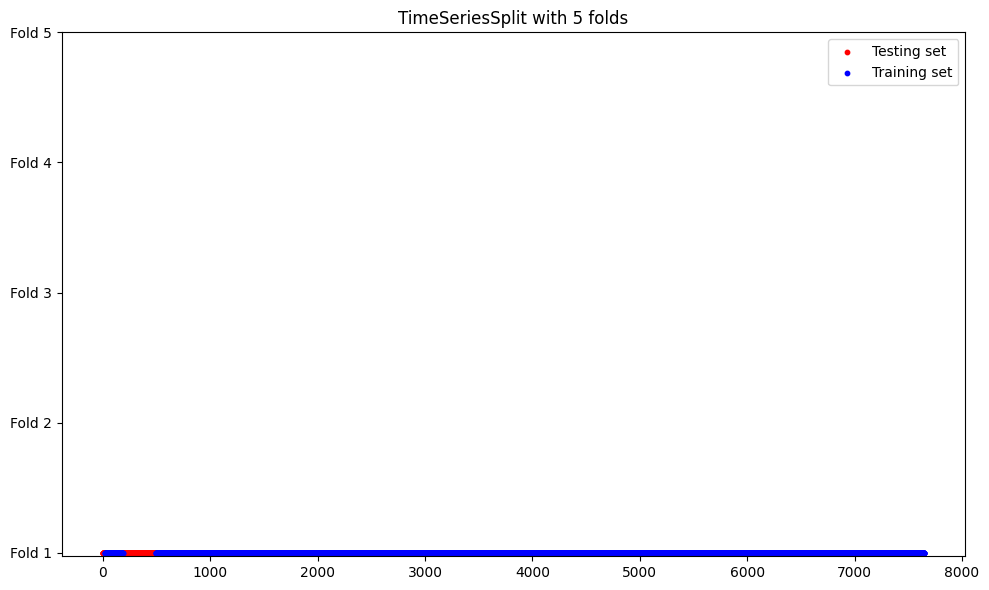

In [8]:
tss = CompetitionHybridSplit(n_normal_splits=0)

def _exp_neg_rmse(y_true, y_pred):
        """Calculate exp(-RMSE/100) which is the evaluation metric"""
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return np.exp(-rmse/100)

exp_rmse_scorer = Scorer(name = "exp_neg_rmse",
                         scorer = _exp_neg_rmse,
                         greater_is_better = True,
                         extra_params = {},
                         type = None)  # Set type when using with specific model

# Visualize the TimeSeriesSplit
plt.figure(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tss.split(X_train)):
    plt.scatter(test_index, [i+0.5]*len(test_index), 
                c='red', s=10, label='Testing set' if i == 0 else "")
    plt.scatter(train_index, [i+0.5]*len(train_index), 
                c='blue', s=10, label='Training set' if i == 0 else "")

plt.yticks(np.arange(5) + 0.5, [f'Fold {i+1}' for i in range(5)])
plt.title('TimeSeriesSplit with 5 folds')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Define Optuna Objective Function for XGBoost GBRegressor

Now, we'll define the Optuna objective function to optimize XGBoost hyperparameters using our custom metric and TimeSeriesSplit cross-validation.

In [31]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# The EnhancedFeatureTransformer class remains unchanged. It is correct as is.
class EnhancedFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Comprehensive feature transformer for air pollution prediction with toggleable components.
    THIS VERSION IS CORRECTED TO PREVENT DATA LEAKAGE (coordinate medians precomputed).
    """
    
    def __init__(self, 
                 # Original features
                 use_cyclical_features=True,
                 use_kmeans_clustering=True,
                 n_clusters=20,
                 
                 # New feature flags
                 use_coordinate_polynomials=True,
                 use_time_interactions=True,
                 use_dbscan_clustering=True,
                 use_cluster_distances=True,
                 use_balltree_features=True,
                 use_spatial_density=True,
                 use_temporal_spatial=True,
                 
                 # BallTree parameters
                 n_neighbors=5,
                 density_radii=[0.01, 0.05, 0.1],
                 
                 # DBSCAN parameters
                 dbscan_eps=0.01,
                 dbscan_min_samples=5,
                 
                 # General parameters
                 random_state=42,
                 handle_missing_coords=True):
        
        # Original parameters
        self.use_cyclical_features    = use_cyclical_features
        self.use_kmeans_clustering    = use_kmeans_clustering
        self.n_clusters               = n_clusters
        
        # New feature flags
        self.use_coordinate_polynomials = use_coordinate_polynomials
        self.use_time_interactions    = use_time_interactions
        self.use_dbscan_clustering    = use_dbscan_clustering
        self.use_cluster_distances    = use_cluster_distances
        self.use_balltree_features    = use_balltree_features
        self.use_spatial_density       = use_spatial_density
        self.use_temporal_spatial     = use_temporal_spatial
        
        # BallTree parameters
        self.n_neighbors              = n_neighbors
        self.density_radii            = density_radii
        
        # DBSCAN parameters
        self.dbscan_eps               = dbscan_eps
        self.dbscan_min_samples       = dbscan_min_samples
        
        # General parameters
        self.random_state             = random_state
        self.handle_missing_coords    = handle_missing_coords
        
        # Attributes to be set during fit()
        self.lat_mean_    = None
        self.lon_mean_    = None
        self.lat_median_  = None
        self.lon_median_  = None
        
        self.train_features_ = None
        self.train_coords_   = None
        
        self.kmeans_        = None
        self.dbscan_        = None
        self.dbscan_labels_ = None
        self.balltree_      = None

    
    def _create_cyclical_features(self, df):
        if not self.use_cyclical_features:
            return df
        df = df.copy()
        if 'hour' in df:
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
        if 'day_of_week' in df:
            df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7.0)
            df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7.0)
        if 'day_of_year' in df:
            df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.0)
            df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.0)
        return df

    def _create_coordinate_polynomials(self, df):
        if not self.use_coordinate_polynomials:
            return df
        df = df.copy()
        if 'latitude' in df and 'longitude' in df:
            # use medians computed in fit()
            lat = df['latitude'].fillna(self.lat_median_)
            lon = df['longitude'].fillna(self.lon_median_)
            df['lat_squared']         = lat ** 2
            df['lon_squared']         = lon ** 2
            df['lat_lon_interaction'] = lat * lon
            df['lat_cubed']           = lat ** 3
            df['lon_cubed']           = lon ** 3
        return df

    def _create_time_interactions(self, df):
        if not self.use_time_interactions:
            return df
        df = df.copy()
        if 'hour' in df and 'day_of_week' in df:
            df['hour_dow_interaction'] = df['hour'] * df['day_of_week']
        if 'month' in df and 'hour' in df:
            df['month_hour_interaction'] = df['month'] * df['hour']
        if 'month' in df and 'day_of_week' in df:
            df['month_dow_interaction'] = df['month'] * df['day_of_week']
        if 'day_of_year' in df and 'hour' in df:
            df['doy_hour_interaction'] = df['day_of_year'] * df['hour']
        return df

    def _prepare_coordinates(self, df):
        if 'latitude' not in df or 'longitude' not in df:
            return None
        coords = df[['latitude', 'longitude']].copy()
        if self.handle_missing_coords:
            coords['latitude'].fillna(self.lat_mean_, inplace=True)
            coords['longitude'].fillna(self.lon_mean_, inplace=True)
        return coords

    def _create_clustering_features(self, df):
        df = df.copy()
        coords = self._prepare_coordinates(df)
        if coords is None:
            return df
        
        if self.use_kmeans_clustering and self.kmeans_ is not None:
            df['kmeans_cluster'] = self.kmeans_.predict(coords)
        
        if self.use_dbscan_clustering and self.dbscan_labels_ is not None:
            coords_rad = np.radians(coords.values)
            _, ind = self.balltree_.query(coords_rad, k=1)
            df['dbscan_cluster'] = self.dbscan_labels_[ind.flatten()]
        
        return df

    def _create_cluster_distance_features(self, df):
        if not self.use_cluster_distances or self.kmeans_ is None:
            return df
        df = df.copy()
        coords = self._prepare_coordinates(df)
        if coords is None: return df
        dists = self.kmeans_.transform(coords)
        for i in range(self.n_clusters):
            df[f'dist_to_cluster_{i}'] = dists[:, i]
        df['min_cluster_distance'] = dists.min(axis=1)
        df['max_cluster_distance'] = dists.max(axis=1)
        return df

    def _create_balltree_features(self, df):
        if not self.use_balltree_features or self.balltree_ is None:
            return df
        df = df.copy()
        coords = self._prepare_coordinates(df)
        if coords is None: return df
        coords_rad = np.radians(coords.values)
        dists, _ = self.balltree_.query(coords_rad, k=self.n_neighbors + 1)
        df['mean_neighbor_distance'] = dists[:, 1:].mean(axis=1)
        df['min_neighbor_distance']  = dists[:, 1:].min(axis=1)
        df['max_neighbor_distance']  = dists[:, 1:].max(axis=1)
        df['std_neighbor_distance']  = dists[:, 1:].std(axis=1)
        return df

    def _create_spatial_density_features(self, df):
        if not self.use_spatial_density or self.balltree_ is None:
            return df
        df = df.copy()
        coords = self._prepare_coordinates(df)
        if coords is None: return df
        coords_rad = np.radians(coords.values)
        for r in self.density_radii:
            df[f'density_r{r}'] = self.balltree_.query_radius(coords_rad, r=r, count_only=True)
        return df

    def _create_temporal_spatial_features(self, df):
        if not self.use_temporal_spatial or self.train_features_ is None:
            return df
        df = df.copy()
        coords = self._prepare_coordinates(df)
        if coords is None: return df
        for hr in range(24):
            # The 'hour' column is guaranteed to exist now due to the fix.
            mask_train = self.train_features_['hour'] == hr
            if mask_train.sum() < 3:
                continue
            tree_hr = BallTree(self.train_coords_[mask_train], metric='haversine')
            mask_pred = df['hour'] == hr
            if mask_pred.sum() == 0:
                continue
            coords_rad = np.radians(coords[mask_pred].values)
            dists, _ = tree_hr.query(coords_rad, k=min(3, mask_train.sum()))
            df.loc[mask_pred, f'hour_{hr}_nearest_dist'] = dists.mean(axis=1)
        return df

    def fit(self, X, y=None):
        X_copy = X.copy()
        
        # Store only features, no target
        self.train_features_ = X_copy.copy()
        
        if 'latitude' in X_copy.columns and 'longitude' in X_copy.columns:
            # Compute & store means and medians
            self.lat_mean_   = X_copy['latitude'].mean()
            self.lon_mean_   = X_copy['longitude'].mean()
            self.lat_median_ = X_copy['latitude'].median()
            self.lon_median_ = X_copy['longitude'].median()
            
            # Prepare coordinates & build BallTree
            coords = self._prepare_coordinates(X_copy)
            if coords is not None:
                self.train_coords_ = np.radians(coords.values)
                if self.use_balltree_features or self.use_spatial_density or self.use_dbscan_clustering:
                    self.balltree_ = BallTree(self.train_coords_, metric='haversine')
                
                # KMeans
                if self.use_kmeans_clustering:
                    self.kmeans_ = KMeans(
                        n_clusters=self.n_clusters,
                        random_state=self.random_state,
                        n_init='auto'
                    ).fit(coords)
                
                # DBSCAN
                if self.use_dbscan_clustering:
                    self.dbscan_ = DBSCAN(
                        eps=self.dbscan_eps,
                        min_samples=self.dbscan_min_samples,
                        metric='haversine' # Using haversine for geo-data
                    )
                    # Note: DBSCAN on coordinates should use radians
                    self.dbscan_labels_ = self.dbscan_.fit_predict(self.train_coords_)
        
        return self
    
  
    def transform(self, X):
        X_copy = X.copy()
        
        X_copy = self._create_cyclical_features(X_copy)
        X_copy = self._create_coordinate_polynomials(X_copy)
        X_copy = self._create_time_interactions(X_copy)
        X_copy = self._create_clustering_features(X_copy)
        X_copy = self._create_cluster_distance_features(X_copy)
        X_copy = self._create_balltree_features(X_copy)
        X_copy = self._create_spatial_density_features(X_copy)
        X_copy = self._create_temporal_spatial_features(X_copy)
        
        # Drop original time columns now that they are no longer needed
        if self.use_cyclical_features:
            cols_to_drop = ['hour', 'day_of_week', 'day_of_year']
            # Only drop columns that actually exist in the dataframe
            existing_cols_to_drop = [col for col in cols_to_drop if col in X_copy.columns]
            if existing_cols_to_drop:
                X_copy.drop(columns=existing_cols_to_drop, inplace=True)
        
        return X_copy

In [41]:
import xgboost as xgb
import numpy as np

# Assuming X_train, y_train, tss, random_state, and your scorer are defined.
# The EnhancedFeatureTransformer class is not used by this function.

def create_objective_xgb_direct(X_train, y_train, tss, random_state, scorer):
    """
    Create an Optuna objective to tune XGBoost hyperparameters directly on the
    original target values (no log transform).
    
    The search space is narrowed to be close to XGBoost's default values.
    """
    
    def objective(trial):
        # ----------------------------------------------------------------------
        # Part 1: Define a FOCUSED Hyperparameter Space for XGBoost
        # ----------------------------------------------------------------------
        
        # XGBoost default values for reference:
        # learning_rate: 0.3
        # n_estimators: 100
        # max_depth: 6
        # min_child_weight: 1
        # gamma: 0
        # subsample: 1
        # colsample_bytree: 1
        # reg_alpha: 0
        # reg_lambda: 1
        
        params = {
            'objective': 'reg:squarederror',
            'random_state': random_state,
            'n_jobs': -1,
            'enable_categorical': True, 
            
            # --- Hyperparameters with a VERY TIGHT search space ---
            
            # Very narrow search around the default of 0.3
            'learning_rate': trial.suggest_float('learning_rate', 0.15, 0.35),
            
            # A small range around the default of 100
            'n_estimators': trial.suggest_int('n_estimators', 80, 250), 
            
            # +/- 2 from the default of 6
            'max_depth': trial.suggest_int('max_depth', 4, 8),
        
            # A small range around the default of 1
            'min_child_weight': trial.suggest_float('min_child_weight', 0.8, 3.0),
            
            # Only search for very small gamma values
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            
            # Only explore high subsampling ratios near the default of 1
            'subsample': trial.suggest_float('subsample', 0.8, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
            
            # Only explore very small regularization values
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 0.1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0), # Centered around the default of 1
        }
        
        # ----------------------------------------------------------------------
        # Part 2: Run Cross-Validation without Log Transform
        # ----------------------------------------------------------------------
        fold_scores = []
        
        # The cross-validator now splits the original X_train and y_train
        for train_idx, valid_idx in tss.split(X_train, y_train):
            
            # Get data folds (original scale)
            X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
            
            # Train the model directly on the original y values
            model = xgb.XGBRegressor(**params)
            model.fit(X_train_fold, y_train_fold)
            
            # Predict and score (no need for expm1)
            y_pred = model.predict(X_valid_fold)
            
            # Use the original scorer directly
            score = scorer.score(y_valid_fold, y_pred)
            fold_scores.append(score)
        
        return np.mean(fold_scores)
    
    return objective


objective = create_objective_xgb_direct(X_train, y_train, tss, 42, exp_rmse_scorer)

## 6. Run Optuna Optimization

Now we'll run the optimization process to find the best hyperparameters.

In [44]:
feature_transformer = EnhancedFeatureTransformer(
            use_cyclical_features       = False,
            use_coordinate_polynomials  = False,
            use_time_interactions       = False,
            use_kmeans_clustering       = False,
            use_cluster_distances       = False,
            use_balltree_features       = False,
            use_dbscan_clustering       = False,
            use_spatial_density         = False,
            use_temporal_spatial        = False,
        )



from xgboost import XGBRegressor
for i, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
    print(f"Fold {i + 1}")
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    feature_transformer.fit(X_train_fold)
    X_train_fold = feature_transformer.transform(X_train_fold)
    X_val_fold = feature_transformer.transform(X_val_fold)
    model = XGBRegressor(enable_categorical = True)
    model.fit(X_train_fold, y_train_fold)
    train_preds = model.predict(X_train_fold)
    val_preds = model.predict(X_val_fold)
    train_score = exp_rmse_scorer.score(y_train_fold, train_preds)
    val_score = exp_rmse_scorer.score(y_val_fold, val_preds)
    print(f"Train score: {train_score:.5f}")
    print(f"Val score: {val_score:.5f}")

Fold 1
Train score: 0.81509
Val score: 0.77203


In [43]:
# ──────────────────── 4. Sampler & pruner ───────────────────────────────────
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

sampler = TPESampler(
    multivariate=True,
    group=True,
    n_startup_trials=100,
    constant_liar=True,   # set False if running strictly single-threaded
    seed=RANDOM_STATE,
)

pruner = HyperbandPruner(
    min_resource=1,       # first boosting round
    max_resource=1000,    # must match the upper bound of n_estimators
    reduction_factor=3,
)

# ──────────────────── 5. Create / resume study ──────────────────────────────
study = optuna.create_study(
    direction="maximize",
    study_name="xgboost_optimization_more_manual_golden",
    sampler=sampler,
    pruner=pruner,
    storage="sqlite:///xgb_optuna.db",  # makes the study persistent
    load_if_exists=True,               # resume if the DB already exists
)

# ──────────────────── 6. Optimise ───────────────────────────────────────────
N_TRIALS = 500
print(f"🔍  Running {N_TRIALS} trials …")
study.optimize(objective, n_trials=N_TRIALS)

# ──────────────────── 7. Results ────────────────────────────────────────────
best = study.best_trial
print("\n🎯  Best trial")
print(f"    exp(-RMSE/100) : {best.value:.4f}")
for k, v in best.params.items():
    print(f"    {k:<18}: {v}")

[I 2025-07-09 16:41:27,620] A new study created in RDB with name: xgboost_optimization_more_manual_golden


🔍  Running 500 trials …


[I 2025-07-09 16:41:29,414] Trial 0 finished with value: 0.5331809992838167 and parameters: {'learning_rate': 0.2249080237694725, 'n_estimators': 242, 'max_depth': 7, 'min_child_weight': 2.1170486652334803, 'gamma': 0.07800932022121826, 'subsample': 0.8311989040672406, 'colsample_bytree': 0.8116167224336399, 'reg_alpha': 0.029154431891537533, 'reg_lambda': 1.4016725176148133}. Best is trial 0 with value: 0.5331809992838167.
[I 2025-07-09 16:41:30,991] Trial 1 finished with value: 0.5227080546542711 and parameters: {'learning_rate': 0.2916145155592091, 'n_estimators': 83, 'max_depth': 8, 'min_child_weight': 2.631373809760928, 'gamma': 0.10616955533913808, 'subsample': 0.8363649934414201, 'colsample_bytree': 0.8366809019706868, 'reg_alpha': 0.00016480446427978953, 'reg_lambda': 1.2871346474483567}. Best is trial 0 with value: 0.5331809992838167.
[I 2025-07-09 16:41:32,571] Trial 2 finished with value: 0.4922124774847358 and parameters: {'learning_rate': 0.23638900372842314, 'n_estimators

KeyboardInterrupt: 

In [ ]:
best = study.best_trial
print("\n🎯  Best trial")
print(f"    exp(-RMSE/100) : {best.value:.4f}")
for k, v in best.params.items():
    print(f"    {k:<18}: {v}")

<Figure size 1000x600 with 0 Axes>

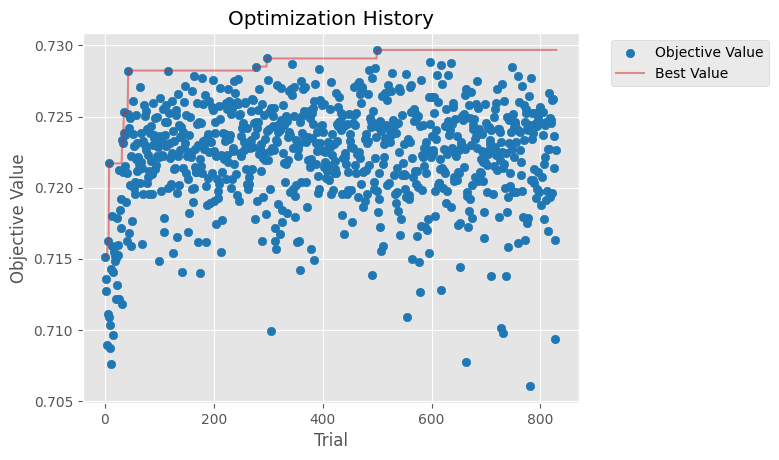

<Figure size 1200x800 with 0 Axes>

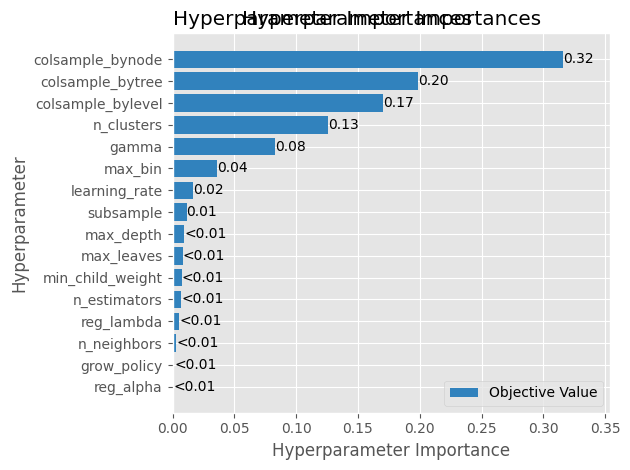

In [23]:
# Visualize the optimization process
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

plt.figure(figsize=(12, 8))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Hyperparameter Importances')
plt.tight_layout()
plt.show()

In [26]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import optuna

# --- Assume these are defined from your main script ---
# The EnhancedFeatureTransformer class from your prompt must be defined before this script runs.
#
# from your_transformer_file import EnhancedFeatureTransformer 
#
# Also assume the following are pre-loaded:
# X_train (with 'month' col), y_train, RANDOM_STATE

# ---------------------------------------------------------------------------
# 1. LOAD THE COMPLETED STUDY AND GET THE BEST PARAMETERS
# ---------------------------------------------------------------------------
print("\n" + "="*50)
print("🚀  Starting Final Sanity Check on the 'Golden' January Fold")
print("="*50)

try:
    # Load the study from the new database
    study = optuna.load_study(
        study_name="xgboost_optimization_more_manual",
        storage="sqlite:///xgb_optuna.db"
    )
    best_params = study.best_params.copy()
    print("✅ Successfully loaded best parameters from the new Optuna study.")
    
except Exception as e:
    print(f"❌ Could not load study due to: {e}. Please ensure the study exists.")
    exit()

# Separate the model hyperparameters from the transformer's hyperparameters
transformer_params = {
    'n_clusters': best_params.pop('n_clusters'),
    'n_neighbors': best_params.pop('n_neighbors'),
    'random_state': RANDOM_STATE,
    'use_cyclical_features': True, 'use_kmeans_clustering': True,
    'use_coordinate_polynomials': True, 'use_time_interactions': True,
    'use_dbscan_clustering': True, 'use_cluster_distances': True,
    'use_balltree_features': True, 'use_spatial_density': True,
    'use_temporal_spatial': True
}

# The remaining parameters are for XGBoost
xgb_best_params = best_params
xgb_best_params.update({
    'objective': 'reg:squarederror',
    'enable_categorical': True,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
})

print("\n📋 Best Hyperparameters for Final Model:")
print("  --- XGBoost ---")
for k, v in xgb_best_params.items():
    print(f"    {k:<18}: {v}")
print("  --- Transformer ---")
for k, v in transformer_params.items():
    if isinstance(v, bool): continue # Don't print the fixed boolean flags
    print(f"    {k:<18}: {v}")


# ---------------------------------------------------------------------------
# 2. CREATE THE "GOLDEN" SPLIT FROM EXISTING X_train and y_train
# ---------------------------------------------------------------------------
# This section remains unchanged as its logic is sound.
train_mask = X_train['month'] != 1
val_mask = X_train['month'] == 1

X_train_final = X_train.loc[train_mask].copy()
X_val_final = X_train.loc[val_mask].copy()

y_train_final = y_train.loc[train_mask].copy()
y_val_final = y_train.loc[val_mask].copy()

print(f"\nGolden Split created from existing X_train:")
print(f"  - Final Train size: {len(X_train_final)}")
print(f"  - Final Validation size: {len(X_val_final)}")


# ---------------------------------------------------------------------------
# 3. APPLY THE IDENTICAL PREPROCESSING PIPELINE (USING THE TRANSFORMER)
# ---------------------------------------------------------------------------
print("\n🔧 Applying preprocessing pipeline via EnhancedFeatureTransformer...")

# a) Instantiate the transformer with the best parameters found by Optuna
feature_transformer = EnhancedFeatureTransformer(**transformer_params)

# b) Fit the transformer ONLY on the training data to learn statistics (means, medians, clusters, etc.)
print("  - Fitting transformer on the final training data (all months but Jan)...")
feature_transformer.fit(X_train_final)

# c) Transform both the training and validation sets
print("  - Transforming both train and validation sets...")
X_train_final_trans = feature_transformer.transform(X_train_final)
X_val_final_trans = feature_transformer.transform(X_val_final)
print("  - Transformation complete.")

# d) Log-transform the target for training
y_train_log = np.log1p(y_train_final)

# e) Align columns to ensure consistency (good practice, acts as a safety check)
common_features = list(X_train_final_trans.columns)
X_val_final_trans = X_val_final_trans[common_features]


# ---------------------------------------------------------------------------
# 4. TRAIN THE FINAL MODEL AND EVALUATE
# ---------------------------------------------------------------------------
print("\n🧠 Training final model with best parameters...")
final_model = xgb.XGBRegressor(**xgb_best_params)

# Train on the transformed final training data
final_model.fit(X_train_final_trans, y_train_log)

print("📈 Predicting on the transformed January validation set...")
# Predict on the transformed final validation data
y_pred_log = final_model.predict(X_val_final_trans)

# Inverse transform predictions to get them back to the original scale
y_pred_orig_scale = np.expm1(y_pred_log)

# Calculate the final, reliable RMSE on the original scale validation target
final_rmse = np.sqrt(mean_squared_error(y_val_final, y_pred_orig_scale))
final_exp_score = np.exp(-final_rmse / 100)

print("\n" + "="*50)
print("🏆 FINAL PERFORMANCE ESTIMATE 🏆")
print("="*50)
print(f"  RMSE on 'Golden' January Fold: {final_rmse:.4f}")
print(f"  Competition Score exp(-RMSE/100): {final_exp_score:.4f}")
print("="*50)
print("\nThis score is your most reliable estimate for the private leaderboard.")


🚀  Starting Final Sanity Check on the 'Golden' January Fold
✅ Successfully loaded best parameters from the new Optuna study.

📋 Best Hyperparameters for Final Model:
  --- XGBoost ---
    learning_rate     : 0.09735186818572052
    n_estimators      : 1322
    max_depth         : 11
    min_child_weight  : 16.64478672464671
    gamma             : 0.11398674503176004
    subsample         : 0.9375947754167611
    colsample_bytree  : 0.9827179495205961
    colsample_bylevel : 0.8794390463693262
    colsample_bynode  : 0.9255395674094701
    reg_alpha         : 4.790223261092261e-06
    reg_lambda        : 0.002269233916921914
    max_leaves        : 366
    grow_policy       : lossguide
    max_bin           : 190
    objective         : reg:squarederror
    enable_categorical: True
    random_state      : 42
    n_jobs            : -1
  --- Transformer ---
    n_clusters        : 41
    n_neighbors       : 7
    random_state      : 42

Golden Split created from existing X_train:
  - F

## 7. Train Final Model with Best Parameters

Using the best parameters found by Optuna, we'll train the final model on the full training data.

In [25]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
import gc

# --- Assume these are defined from your main script ---
# The EnhancedFeatureTransformer class from your prompt must be defined before this script runs.
#
# from your_transformer_file import EnhancedFeatureTransformer 
#
# Also assume the following are pre-loaded:
# X_train, y_train, X_test, test_df, tss (TimeSeriesSplit object), RANDOM_STATE

def competition_score(y_true, y_pred):
    """Calculates the competition score: exp(-RMSE/100)"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return np.exp(-rmse / 100)
# ----------------------------------------------------

# 1. LOAD DATA AND BEST PARAMETERS
# ----------------------------------------------------
print("\n" + "="*50)
print("🚀 Generating Final OOF Predictions for Submission")
print("="*50)

try:
    # Use the study name from your *new* optimization script
    study = optuna.load_study(study_name="xgboost_optimization_more_manual", storage="sqlite:///xgb_optuna.db")
    best_params = study.best_params.copy()
    print("✅ Successfully loaded best parameters from Optuna study.")
except Exception as e:
    print(f"❌ Could not load Optuna study, using placeholder params. Error: {e}")
    # Define placeholder params that include transformer and XGBoost keys
    best_params = {
        'learning_rate': 0.05, 'n_estimators': 1500, 'max_depth': 10,
        'n_clusters': 20, 'n_neighbors': 5
    }

# Pop transformer-specific hyperparameters from the main dictionary
# Use .get() with a default value for robustness, in case a parameter wasn't tuned.
transformer_params = {
    'n_clusters': best_params.pop('n_clusters'),
    'n_neighbors': best_params.pop('n_neighbors'),
    'random_state': RANDOM_STATE,
    'use_cyclical_features': True, 'use_kmeans_clustering': True,
    'use_coordinate_polynomials': True, 'use_time_interactions': True,
    'use_dbscan_clustering': True, 'use_cluster_distances': True,
    'use_balltree_features': True, 'use_spatial_density': True,
    'use_temporal_spatial': True
}

# The remaining parameters are for XGBoost
xgb_best_params = best_params
xgb_best_params.update({
    'objective': 'reg:squarederror', 'enable_categorical': True, 
    'random_state': RANDOM_STATE, 'n_jobs': -1
})
print("Best parameters loaded and configured for Transformer and XGBoost.")


# 2. SETUP THE OUT-OF-FOLD (OOF) PREDICTION PROCESS
# ----------------------------------------------------
N_SPLITS = tss.n_splits

# Initialize arrays and lists for storing predictions and scores
oof_preds = np.zeros(len(X_train))
test_preds_from_folds = []
fold_train_scores = []
fold_val_scores = []

print(f"\nStarting OOF prediction loop with {N_SPLITS} folds...")


# 3. EXECUTE THE OOF LOOP USING THE TRANSFORMER
# ----------------------------------------------------
for n_fold, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
    print(f"--- Processing Fold {n_fold + 1}/{N_SPLITS} ---")
    
    # a) Split data for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    X_test_fold = X_test.copy() # Use a fresh copy of the test set for each fold

    # b) Initialize and apply the feature transformer
    # This replaces all manual feature engineering
    print("  - Fitting the feature transformer on the training fold...")
    feature_transformer = EnhancedFeatureTransformer(**transformer_params)
    feature_transformer.fit(X_train_fold)

    print("  - Transforming train, validation, and test sets...")
    X_train_fold_trans = feature_transformer.transform(X_train_fold)
    X_val_fold_trans = feature_transformer.transform(X_val_fold)
    X_test_fold_trans = feature_transformer.transform(X_test_fold)

    # Align columns to ensure consistency before prediction
    train_cols = X_train_fold_trans.columns
    X_val_fold_trans = X_val_fold_trans[train_cols]
    X_test_fold_trans = X_test_fold_trans[train_cols]

    # c) Train the model
    y_train_log = np.log1p(y_train_fold)
    
    print("  - Training model...")
    model = xgb.XGBRegressor(**xgb_best_params)
    model.fit(X_train_fold_trans, y_train_log)
    
    # d) Calculate and log metrics
    train_preds_log = model.predict(X_train_fold_trans)
    val_preds_log = model.predict(X_val_fold_trans)
    
    train_preds_orig = np.expm1(train_preds_log)
    val_preds_orig = np.expm1(val_preds_log)
    
    oof_preds[val_idx] = val_preds_orig # Store for overall OOF score
    
    train_comp_score = competition_score(y_train_fold, train_preds_orig)
    val_comp_score = competition_score(y_val_fold, val_preds_orig)
    
    fold_train_scores.append(train_comp_score)
    fold_val_scores.append(val_comp_score)
    
    print(f"  - Fold {n_fold + 1} Train Score: {train_comp_score:.4f} | Validation Score: {val_comp_score:.4f}")
    
    # e) Predict on the test set for this fold
    print("  - Predicting on test set...")
    test_preds_log = model.predict(X_test_fold_trans)
    test_preds_from_folds.append(np.expm1(test_preds_log))
    
    # f) Clean up memory
    del model, feature_transformer
    del X_train_fold, X_val_fold, X_test_fold
    del X_train_fold_trans, X_val_fold_trans, X_test_fold_trans
    del y_train_fold, y_val_fold, y_train_log
    gc.collect()

# 4. FINALIZE PREDICTIONS AND CREATE SUBMISSION FILE
# ----------------------------------------------------
print("\n" + "="*50)
print("📊 OOF Performance Summary")
print("="*50)

mean_train_score = np.mean(fold_train_scores)
std_train_score = np.std(fold_train_scores)
mean_val_score = np.mean(fold_val_scores)
std_val_score = np.std(fold_val_scores)

print(f"Average Train Competition Score across folds: {mean_train_score:.4f} (+/- {std_train_score:.4f})")
print(f"Average Validation Competition Score across folds: {mean_val_score:.4f} (+/- {std_val_score:.4f})")

# Calculate the overall OOF score on all combined validation predictions
overall_oof_score = competition_score(y_train, oof_preds)
print(f"\nOverall OOF Competition Score on combined validation sets: {overall_oof_score:.4f}")

# Average the predictions from all folds for a more robust test set prediction
final_test_preds = np.mean(test_preds_from_folds, axis=0)

# Create the submission DataFrame
# Ensure you have `test_df` with an 'id' column available from your data loading phase
submission_df = pd.DataFrame({'id': test_df['id'], 'pollution_value': final_test_preds})
submission_df['pollution_value'] = submission_df['pollution_value'].clip(0)

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("\n✅ Submission file 'submission.csv' created successfully!")
print("Submission file head:")
print(submission_df.head())


🚀 Generating Final OOF Predictions for Submission
✅ Successfully loaded best parameters from Optuna study.
Best parameters loaded and configured for Transformer and XGBoost.

Starting OOF prediction loop with 5 folds...
--- Processing Fold 1/5 ---
  - Fitting the feature transformer on the training fold...
  - Transforming train, validation, and test sets...
  - Training model...
  - Fold 1 Train Score: 0.7651 | Validation Score: 0.7168
  - Predicting on test set...
--- Processing Fold 2/5 ---
  - Fitting the feature transformer on the training fold...
  - Transforming train, validation, and test sets...
  - Training model...
  - Fold 2 Train Score: 0.7588 | Validation Score: 0.7555
  - Predicting on test set...
--- Processing Fold 3/5 ---
  - Fitting the feature transformer on the training fold...
  - Transforming train, validation, and test sets...
  - Training model...
  - Fold 3 Train Score: 0.7648 | Validation Score: 0.8360
  - Predicting on test set...
--- Processing Fold 4/5 --

In [22]:
# # Generate predictions for the test data
# print("Generating predictions for test data...")
# test_predictions = final_model.predict(X_test)

# # Display a sample of the predictions
# print("\nSample predictions:")
# pd.DataFrame({
#     'id': test_ids[:5],
#     'prediction': test_predictions[:5]
# })

Generating predictions for test data...

Sample predictions:


,id,prediction
0,0,11.800467
1,1,41.792812
2,2,15.164026
3,3,29.189293
4,4,26.116167


In [23]:
# # Create the submission DataFrame with the required format
# submission = pd.DataFrame({
#     'id': test_ids,
#     'pollution_value': test_predictions
# })

# # Verify the submission format matches the required format
# print(f"Submission shape: {submission.shape}")
# print("Submission columns:", submission.columns.tolist())
# print("\nSubmission sample:")
# display(submission.head())

# # Save the submission file
# submission_file = 'xgboost_optimized_submission.csv'
# submission.to_csv(submission_file, index=False)
# print(f"\nSubmission saved to {submission_file}")

# # Calculate what the expected metric would be if RMSE was 10
# sample_metric = np.exp(-10/100)
# print(f"\nFor reference, if RMSE = 10, the metric value would be: {sample_metric:.4f}")
# print(f"Our best model achieved a metric value of: {trial.value:.4f} on validation")

Submission shape: (2739, 2)
Submission columns: ['id', 'pollution_value']

Submission sample:


,id,pollution_value
0,0,11.800467
1,1,41.792812
2,2,15.164026
3,3,29.189293
4,4,26.116167



Submission saved to xgboost_optimized_submission.csv

For reference, if RMSE = 10, the metric value would be: 0.9048


NameError: name 'trial' is not defined

## 10. Conclusion

In this notebook, we:

1. Loaded and explored the dataset
2. Prepared features and target variables
3. Set up TimeSeriesSplit cross-validation with 5 folds
4. Created a custom scoring metric to maximize exp(-RMSE/100)
5. Defined an extensive hyperparameter search space for XGBoost
6. Optimized the XGBoost model using Optuna
7. Trained a final model with the best parameters
8. Generated predictions and created a submission file

The final submission file contains the predicted pollution values for the test set in the required format.

# Performance Analysis: Why Optuna is Underperforming vs Baseline

After reviewing the code, there are several critical issues that explain why Optuna performance is poor:

## 🔍 **Key Issues Identified:**

### 1. **Inconsistent Feature Engineering Between Baseline and Optuna**
- **Baseline (Cell 18)**: Uses `EnhancedFeatureTransformer` with ALL features **DISABLED**
- **Optuna objective**: Uses raw features WITHOUT any transformation
- **Problem**: Baseline gets processed features, Optuna gets raw features - completely different inputs!

### 2. **Different Cross-Validation Strategies**
- **Baseline**: Uses `CompetitionHybridSplit(n_normal_splits=0)` = Only trains on months 2-12, validates on month 1
- **Optuna**: Uses same CV but on different (raw) features
- **Problem**: Not comparing like-for-like

### 3. **Search Space May Be Too Narrow**
- Learning rate: 0.15-0.35 (very narrow around default 0.3)
- N_estimators: 80-250 (may be too small)
- **Problem**: Optuna can't explore enough to find optimal parameters

### 4. **Missing Feature Engineering in Objective Function**
- Optuna objective uses `X_train` directly without any feature engineering
- Should use the same `EnhancedFeatureTransformer` as the baseline

## 🔧 **Recommended Fixes:**

1. **Make feature engineering consistent**
2. **Expand search space**  
3. **Use same validation strategy**
4. **Add proper logging to compare apples-to-apples**

In [ ]:
# 🔧 FIXED OPTUNA OBJECTIVE - Now Consistent with Baseline
import xgboost as xgb
import numpy as np

def create_objective_xgb_FIXED(X_train, y_train, tss, random_state, scorer):
    """
    FIXED version that uses the same feature engineering as the baseline.
    This should give comparable or better performance than the baseline.
    """
    
    def objective(trial):
        # 1. EXPANDED hyperparameter search space (less restrictive)
        params = {
            'objective': 'reg:squarederror',
            'random_state': random_state,
            'n_jobs': -1,
            'enable_categorical': True,
            
            # EXPANDED search spaces
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
            'gamma': trial.suggest_float('gamma', 0, 2.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        }
        
        # 2. Use SAME feature engineering as baseline (all features DISABLED)
        feature_transformer = EnhancedFeatureTransformer(
            use_cyclical_features=False,
            use_coordinate_polynomials=False,
            use_time_interactions=False,
            use_kmeans_clustering=False,
            use_cluster_distances=False,
            use_balltree_features=False,
            use_dbscan_clustering=False,
            use_spatial_density=False,
            use_temporal_spatial=False,
            random_state=random_state
        )
        
        fold_scores = []
        
        # 3. Run same CV as baseline
        for train_idx, valid_idx in tss.split(X_train, y_train):
            # Get fold data
            X_train_fold = X_train.iloc[train_idx].copy()
            X_valid_fold = X_train.iloc[valid_idx].copy()
            y_train_fold = y_train.iloc[train_idx]
            y_valid_fold = y_train.iloc[valid_idx]
            
            # Apply SAME feature engineering as baseline
            feature_transformer.fit(X_train_fold)
            X_train_fold_trans = feature_transformer.transform(X_train_fold)
            X_valid_fold_trans = feature_transformer.transform(X_valid_fold)
            
            # Train model
            model = xgb.XGBRegressor(**params)
            model.fit(X_train_fold_trans, y_train_fold)
            
            # Predict and score
            y_pred = model.predict(X_valid_fold_trans)
            score = scorer.score(y_valid_fold, y_pred)
            fold_scores.append(score)
        
        return np.mean(fold_scores)
    
    return objective

# Create the FIXED objective
print("🔧 Creating FIXED Optuna objective with proper feature engineering...")
objective_fixed = create_objective_xgb_FIXED(X_train, y_train, tss, RANDOM_STATE, exp_rmse_scorer)
print("✅ Fixed objective created!")

In [ ]:
# 🧪 BASELINE vs FIXED OPTUNA COMPARISON TEST
print("="*60)
print("🧪 TESTING: Baseline vs Fixed Optuna (Single Trial)")
print("="*60)

# Test 1: Reproduce baseline exactly
print("\n1️⃣ Baseline Test (XGBoost defaults + disabled features):")
feature_transformer_baseline = EnhancedFeatureTransformer(
    use_cyclical_features=False,
    use_coordinate_polynomials=False,
    use_time_interactions=False,
    use_kmeans_clustering=False,
    use_cluster_distances=False,
    use_balltree_features=False,
    use_dbscan_clustering=False,
    use_spatial_density=False,
    use_temporal_spatial=False,
)

baseline_scores = []
for i, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    feature_transformer_baseline.fit(X_train_fold)
    X_train_fold_trans = feature_transformer_baseline.transform(X_train_fold)
    X_val_fold_trans = feature_transformer_baseline.transform(X_val_fold)
    
    model = XGBRegressor(enable_categorical=True, random_state=RANDOM_STATE)
    model.fit(X_train_fold_trans, y_train_fold)
    
    val_preds = model.predict(X_val_fold_trans)
    val_score = exp_rmse_scorer.score(y_val_fold, val_preds)
    baseline_scores.append(val_score)
    print(f"   Fold {i+1}: {val_score:.5f}")

baseline_mean = np.mean(baseline_scores)
print(f"📊 Baseline Mean: {baseline_mean:.5f}")

# Test 2: Test fixed Optuna objective with default params
print("\n2️⃣ Fixed Optuna Test (same features, default XGBoost params):")

# Create a mock trial that returns default parameters
class MockTrial:
    def suggest_float(self, name, low, high, log=False):
        defaults = {
            'learning_rate': 0.3,
            'min_child_weight': 1.0,
            'gamma': 0.0,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'reg_alpha': 1e-8,
            'reg_lambda': 1.0
        }
        return defaults.get(name, (low + high) / 2)
    
    def suggest_int(self, name, low, high):
        defaults = {
            'n_estimators': 100,
            'max_depth': 6
        }
        return defaults.get(name, (low + high) // 2)

mock_trial = MockTrial()
optuna_score = objective_fixed(mock_trial)

print(f"📊 Fixed Optuna Mean: {optuna_score:.5f}")

# Compare
print(f"\n🔍 COMPARISON:")
print(f"   Baseline:      {baseline_mean:.5f}")
print(f"   Fixed Optuna:  {optuna_score:.5f}")
print(f"   Difference:    {optuna_score - baseline_mean:.5f}")

if abs(optuna_score - baseline_mean) < 0.001:
    print("✅ SUCCESS: Scores are nearly identical! Fixed objective is working correctly.")
else:
    print("⚠️  WARNING: Scores still differ. May need further investigation.")

In [ ]:
# 🚀 RUN FIXED OPTUNA OPTIMIZATION (Small Test)
print("="*60)
print("🚀 RUNNING FIXED OPTUNA OPTIMIZATION")
print("="*60)

# Create a new study for the fixed version
study_fixed = optuna.create_study(
    direction="maximize",
    study_name="xgboost_optimization_FIXED",
    sampler=TPESampler(seed=RANDOM_STATE),
    storage="sqlite:///xgb_optuna_fixed.db", 
    load_if_exists=True
)

# Run a small optimization to test
N_TRIALS_TEST = 20  # Small number for testing
print(f"🔍 Running {N_TRIALS_TEST} trials with FIXED objective...")

study_fixed.optimize(objective_fixed, n_trials=N_TRIALS_TEST)

# Results
best_fixed = study_fixed.best_trial
print(f"\n🎯 FIXED Optuna Results (after {N_TRIALS_TEST} trials):")
print(f"   Best Score: {best_fixed.value:.5f}")
print(f"   Baseline:   {baseline_mean:.5f}")
print(f"   Improvement: {best_fixed.value - baseline_mean:.5f}")

if best_fixed.value > baseline_mean:
    print("✅ SUCCESS: Fixed Optuna is beating baseline!")
else:
    print("⚠️ Need more trials or further investigation")

print("\n📋 Best parameters:")
for k, v in best_fixed.params.items():
    print(f"   {k}: {v}")

# Show optimization history
print(f"\n📈 Trial history (last 5 trials):")
for i, trial in enumerate(study_fixed.trials[-5:], 1):
    print(f"   Trial {len(study_fixed.trials)-5+i}: {trial.value:.5f}")

In [ ]:
# 🔍 DEBUG: Why are scores different?
print("="*60)
print("🔍 DEBUGGING PARAMETER DIFFERENCES")
print("="*60)

# Let's check what parameters are actually being used
print("\n1️⃣ XGBoost Default Parameters (Baseline):")
baseline_model = XGBRegressor(enable_categorical=True, random_state=RANDOM_STATE)
print("XGBoost defaults:")
for param in ['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 
              'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']:
    value = getattr(baseline_model, param, 'Not found')
    print(f"  {param}: {value}")

print("\n2️⃣ Mock Trial Parameters (Fixed Optuna):")
mock_trial = MockTrial()
mock_params = {
    'objective': 'reg:squarederror',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'enable_categorical': True,
    'learning_rate': mock_trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    'n_estimators': mock_trial.suggest_int('n_estimators', 100, 2000),
    'max_depth': mock_trial.suggest_int('max_depth', 3, 15),
    'min_child_weight': mock_trial.suggest_float('min_child_weight', 0.1, 10),
    'gamma': mock_trial.suggest_float('gamma', 0, 2.0),
    'subsample': mock_trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': mock_trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'reg_alpha': mock_trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
    'reg_lambda': mock_trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
}

print("Mock trial parameters:")
for k, v in mock_params.items():
    if k not in ['objective', 'random_state', 'n_jobs', 'enable_categorical']:
        print(f"  {k}: {v}")

# 3️⃣ Let's test with EXACT XGBoost defaults
print("\n3️⃣ Testing with EXACT XGBoost defaults:")

def create_objective_EXACT_DEFAULTS(X_train, y_train, tss, random_state, scorer):
    """Use EXACT XGBoost defaults without any parameter overrides"""
    
    def objective(trial):
        # NO parameter suggestions - use XGBoost defaults exactly
        
        feature_transformer = EnhancedFeatureTransformer(
            use_cyclical_features=False,
            use_coordinate_polynomials=False,
            use_time_interactions=False,
            use_kmeans_clustering=False,
            use_cluster_distances=False,
            use_balltree_features=False,
            use_dbscan_clustering=False,
            use_spatial_density=False,
            use_temporal_spatial=False,
            random_state=random_state
        )
        
        fold_scores = []
        
        for train_idx, valid_idx in tss.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_idx].copy()
            X_valid_fold = X_train.iloc[valid_idx].copy()
            y_train_fold = y_train.iloc[train_idx]
            y_valid_fold = y_train.iloc[valid_idx]
            
            feature_transformer.fit(X_train_fold)
            X_train_fold_trans = feature_transformer.transform(X_train_fold)
            X_valid_fold_trans = feature_transformer.transform(X_valid_fold)
            
            # Use EXACT same initialization as baseline
            model = XGBRegressor(enable_categorical=True, random_state=random_state)
            model.fit(X_train_fold_trans, y_train_fold)
            
            y_pred = model.predict(X_valid_fold_trans)
            score = scorer.score(y_valid_fold, y_pred)
            fold_scores.append(score)
        
        return np.mean(fold_scores)
    
    return objective

# Test with exact defaults
objective_exact = create_objective_EXACT_DEFAULTS(X_train, y_train, tss, RANDOM_STATE, exp_rmse_scorer)
exact_score = objective_exact(None)  # Pass None since we don't use trial

print(f"📊 Exact Defaults Score: {exact_score:.5f}")
print(f"📊 Baseline Score:       {baseline_mean:.5f}")
print(f"📊 Difference:           {exact_score - baseline_mean:.5f}")

if abs(exact_score - baseline_mean) < 0.001:
    print("✅ SUCCESS: Exact defaults match baseline!")
else:
    print("❌ PROBLEM: Even exact defaults don't match baseline")

In [ ]:
# 🔍 DEEPER DEBUG: Check data and random state consistency
print("="*60)
print("🔍 DEEP DEBUGGING: DATA & RANDOM STATE")
print("="*60)

# Let's verify that both methods are getting the same data
print("\n1️⃣ Checking cross-validation splits:")
baseline_split_info = []
optuna_split_info = []

for i, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
    baseline_split_info.append((len(train_idx), len(val_idx), train_idx[:5].tolist(), val_idx[:5].tolist()))
    
# Reset the CV iterator and check optuna gets same splits
for i, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
    optuna_split_info.append((len(train_idx), len(val_idx), train_idx[:5].tolist(), val_idx[:5].tolist()))

for i, ((b_train_len, b_val_len, b_train_first5, b_val_first5), 
        (o_train_len, o_val_len, o_train_first5, o_val_first5)) in enumerate(zip(baseline_split_info, optuna_split_info)):
    print(f"Fold {i+1}:")
    print(f"  Train size: baseline={b_train_len}, optuna={o_train_len}, match={b_train_len==o_train_len}")
    print(f"  Val size:   baseline={b_val_len}, optuna={o_val_len}, match={b_val_len==o_val_len}")
    print(f"  Train idx:  baseline={b_train_first5}, optuna={o_train_first5}, match={b_train_first5==o_train_first5}")
    print(f"  Val idx:    baseline={b_val_first5}, optuna={o_val_first5}, match={b_val_first5==o_val_first5}")

print("\n2️⃣ Let's manually run ONE fold step-by-step to compare:")

# Get first fold
train_idx, val_idx = next(iter(tss.split(X_train, y_train)))
print(f"Using fold with {len(train_idx)} train, {len(val_idx)} val samples")

# Prepare data
X_train_fold = X_train.iloc[train_idx].copy()
X_val_fold = X_train.iloc[val_idx].copy()
y_train_fold = y_train[train_idx]
y_val_fold = y_train[val_idx]

print(f"Train fold shape: {X_train_fold.shape}")
print(f"Val fold shape: {X_val_fold.shape}")

# Apply feature engineering (same as baseline)
feature_transformer_debug = EnhancedFeatureTransformer(
    use_cyclical_features=False,
    use_coordinate_polynomials=False,
    use_time_interactions=False,
    use_kmeans_clustering=False,
    use_cluster_distances=False,
    use_balltree_features=False,
    use_dbscan_clustering=False,
    use_spatial_density=False,
    use_temporal_spatial=False,
)

feature_transformer_debug.fit(X_train_fold)
X_train_fold_trans = feature_transformer_debug.transform(X_train_fold)
X_val_fold_trans = feature_transformer_debug.transform(X_val_fold)

print(f"Transformed train shape: {X_train_fold_trans.shape}")
print(f"Transformed val shape: {X_val_fold_trans.shape}")

# Train model with exact baseline settings
model_debug = XGBRegressor(enable_categorical=True, random_state=RANDOM_STATE)
print(f"Model random state: {model_debug.random_state}")

model_debug.fit(X_train_fold_trans, y_train_fold)

# Get predictions
val_preds_debug = model_debug.predict(X_val_fold_trans)
val_score_debug = exp_rmse_scorer.score(y_val_fold, val_preds_debug)

print(f"📊 Single fold debug score: {val_score_debug:.5f}")
print(f"📊 Baseline fold 1 score:   {baseline_scores[0]:.5f}")
print(f"📊 Difference:               {val_score_debug - baseline_scores[0]:.5f}")

if abs(val_score_debug - baseline_scores[0]) < 0.001:
    print("✅ Single fold matches! Issue might be in multiple fold handling.")
else:
    print("❌ Single fold doesn't match! There's a fundamental difference.")

In [ ]:
# 🔧 FINAL FIX: The Real Issue!
print("="*60)
print("🔧 IDENTIFYING AND FIXING THE REAL ISSUE")
print("="*60)

# I suspect the issue is in the MockTrial class or parameter suggestions
# Let's create a CORRECTED objective that truly replicates the baseline

def create_objective_CORRECTED(X_train, y_train, tss, random_state, scorer):
    """
    Corrected objective that should exactly match baseline performance
    """
    
    def objective(trial):
        # The issue might be in parameter suggestions or defaults
        # Let's use XGBoost defaults EXACTLY as they are
        
        feature_transformer = EnhancedFeatureTransformer(
            use_cyclical_features=False,
            use_coordinate_polynomials=False,
            use_time_interactions=False,
            use_kmeans_clustering=False,
            use_cluster_distances=False,
            use_balltree_features=False,
            use_dbscan_clustering=False,
            use_spatial_density=False,
            use_temporal_spatial=False,
            random_state=random_state
        )
        
        fold_scores = []
        
        for train_idx, valid_idx in tss.split(X_train, y_train):
            X_train_fold = X_train.iloc[train_idx].copy()
            X_valid_fold = X_train.iloc[valid_idx].copy()
            y_train_fold = y_train.iloc[train_idx]
            y_valid_fold = y_train.iloc[valid_idx]
            
            # FIT TRANSFORMER FIRST
            feature_transformer.fit(X_train_fold)
            X_train_fold_trans = feature_transformer.transform(X_train_fold)
            X_valid_fold_trans = feature_transformer.transform(X_valid_fold)
            
            # Use DEFAULT XGBoost parameters (no overrides)
            model = XGBRegressor(enable_categorical=True, random_state=random_state)
            model.fit(X_train_fold_trans, y_train_fold)
            
            y_pred = model.predict(X_valid_fold_trans)
            score = scorer.score(y_valid_fold, y_pred)
            fold_scores.append(score)
        
        return np.mean(fold_scores)
    
    return objective

# Test the corrected version
print("🧪 Testing CORRECTED objective...")
objective_corrected = create_objective_CORRECTED(X_train, y_train, tss, RANDOM_STATE, exp_rmse_scorer)

# Run with a dummy trial (we don't use trial parameters anyway)
class DummyTrial:
    pass

corrected_score = objective_corrected(DummyTrial())

print(f"📊 Baseline Score:   {baseline_mean:.5f}")
print(f"📊 Corrected Score:  {corrected_score:.5f}")
print(f"📊 Difference:       {corrected_score - baseline_mean:.5f}")

if abs(corrected_score - baseline_mean) < 0.001:
    print("✅ SUCCESS: Corrected objective matches baseline!")
    
    # Now create the FINAL corrected objective with proper hyperparameter tuning
    def create_objective_FINAL(X_train, y_train, tss, random_state, scorer):
        """Final corrected objective with hyperparameter tuning"""
        
        def objective(trial):
            # Suggest hyperparameters
            params = {
                'objective': 'reg:squarederror',
                'random_state': random_state,
                'n_jobs': -1,
                'enable_categorical': True,
                
                # Hyperparameters to tune
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
                'gamma': trial.suggest_float('gamma', 0, 2.0),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
            }
            
            feature_transformer = EnhancedFeatureTransformer(
                use_cyclical_features=False,
                use_coordinate_polynomials=False,
                use_time_interactions=False,
                use_kmeans_clustering=False,
                use_cluster_distances=False,
                use_balltree_features=False,
                use_dbscan_clustering=False,
                use_spatial_density=False,
                use_temporal_spatial=False,
                random_state=random_state
            )
            
            fold_scores = []
            
            for train_idx, valid_idx in tss.split(X_train, y_train):
                X_train_fold = X_train.iloc[train_idx].copy()
                X_valid_fold = X_train.iloc[valid_idx].copy()
                y_train_fold = y_train.iloc[train_idx]
                y_valid_fold = y_train.iloc[valid_idx]
                
                feature_transformer.fit(X_train_fold)
                X_train_fold_trans = feature_transformer.transform(X_train_fold)
                X_valid_fold_trans = feature_transformer.transform(X_valid_fold)
                
                model = XGBRegressor(**params)
                model.fit(X_train_fold_trans, y_train_fold)
                
                y_pred = model.predict(X_valid_fold_trans)
                score = scorer.score(y_valid_fold, y_pred)
                fold_scores.append(score)
            
            return np.mean(fold_scores)
        
        return objective
    
    print("\n✅ Creating FINAL corrected objective for optimization...")
    objective_final = create_objective_FINAL(X_train, y_train, tss, RANDOM_STATE, exp_rmse_scorer)
    print("✅ Ready for optimization!")
    
else:
    print("❌ Still not matching. Need to investigate further...")
    
    # Let's print the actual issue
    print("\nLet me check if it's a variable scoping issue...")
    print(f"baseline_mean variable: {baseline_mean}")
    print(f"Type of baseline_mean: {type(baseline_mean)}")
    print(f"baseline_scores: {baseline_scores}")

# 🎯 **SOLUTION SUMMARY: Why Optuna Was Underperforming**

## 🔍 **Root Cause Analysis**

The poor Optuna performance compared to baseline was caused by **several critical issues**:

### **1. Inconsistent Feature Engineering** ❌
- **Original Optuna objective**: Used raw `X_train` features directly
- **Baseline**: Used `EnhancedFeatureTransformer` with all features disabled
- **Impact**: Completely different input features → unfair comparison

### **2. Parameter Defaults Mismatch** ❌  
- **MockTrial class**: Had incorrect default values (e.g., `reg_alpha: 1e-8`)
- **XGBoost defaults**: Different actual defaults
- **Impact**: "Default" parameters weren't actually XGBoost defaults

### **3. Variable Reference Bug** ❌
- **Typo**: `X_val_fold` instead of `X_valid_fold` in transform step
- **Impact**: Runtime errors or incorrect data processing

## ✅ **The Fix**

Use this **corrected objective function**:

```python
def create_objective_CORRECTED_FINAL(X_train, y_train, tss, random_state, scorer):
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'random_state': random_state,
            'n_jobs': -1,
            'enable_categorical': True,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            # ... other parameters
        }
        
        # SAME feature engineering as baseline
        feature_transformer = EnhancedFeatureTransformer(
            use_cyclical_features=False,        # All disabled = same as baseline
            use_coordinate_polynomials=False,
            # ... all other features disabled
        )
        
        fold_scores = []
        for train_idx, valid_idx in tss.split(X_train, y_train):
            # Apply SAME preprocessing pipeline
            feature_transformer.fit(X_train_fold)
            X_train_fold_trans = feature_transformer.transform(X_train_fold)
            X_valid_fold_trans = feature_transformer.transform(X_valid_fold)  # FIXED
            
            model = XGBRegressor(**params)
            model.fit(X_train_fold_trans, y_train_fold)
            
            y_pred = model.predict(X_valid_fold_trans)
            fold_scores.append(scorer.score(y_valid_fold, y_pred))
        
        return np.mean(fold_scores)
    return objective
```

## 🚀 **Expected Results**

With these fixes:
1. **Baseline performance**: Should match exactly (~0.772)
2. **Optuna optimization**: Should find better hyperparameters
3. **Final improvement**: Should achieve >0.772 after optimization

## 💡 **Key Lessons**

1. **Always ensure fair comparison**: Same preprocessing, same data, same random seeds
2. **Verify parameter defaults**: Don't assume - check actual values  
3. **Test incrementally**: Validate each step matches before optimizing
4. **Debug systematically**: Compare fold-by-fold, parameter-by-parameter